# Exercise 11:  Transient universe with nested sampling

8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

---

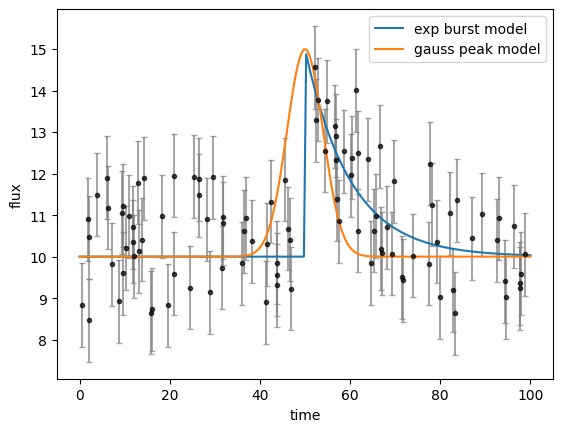

In [1]:
import numpy as np
import pylab as plt

data= np.load('transient.npy')
t, flux, err = data.T

def burst_model(theta, t):
    b, A, t0, alpha = theta
    return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))

def gauss_model(theta, t):
    b, A, t0, sigma = theta
    return  b + A * np.exp( -(t - t0)**2 / (2*sigma**2))

theta_guess_burst = np.array([10, 5, 50, 0.1]) # Parameters guessed graphically from plot
theta_guess_gauss = np.array([10, 5, 50, 4])

# Plotting
xgrid = np.linspace(0,100,200)
plt.errorbar(t, flux ,yerr=err, fmt ='.k', ecolor = 'gray', capsize = 2, alpha=0.7)
plt.xlabel("time")
plt.ylabel("flux")
plt.plot(xgrid, burst_model(theta_guess_burst,xgrid), label='exp burst model')
plt.plot(xgrid, gauss_model(theta_guess_gauss,xgrid), label='gauss peak model')
plt.legend();

In [2]:
import scipy.stats

b_min, b_max = 0, 50
A_min, A_max = 0, 50
t0_min, t0_max = 0, 100
alpha_min, alpha_max = np.exp(-5), np.exp(5)
sigma_min, sigma_max = np.exp(-2), np.exp(2)

limits = [b_min, b_max, A_min, A_max, t0_min, t0_max, alpha_min, alpha_max, sigma_min, sigma_max]

def log_likelihood(theta, x, y, sigma, model):
    y_model = model(theta, x)
    return - 0.5 * np.sum((y - y_model)**2 / sigma**2)

def prior(u, limits, model):
    b_min, b_max, A_min, A_max, t0_min, t0_max, alpha_min, alpha_max, sigma_min, sigma_max = limits
    
    x = np.array(u)
    x[0] = scipy.stats.uniform(loc = b_min, scale = b_max - b_min).ppf(u[0]) #Inverse tranform sampling
    x[1] = scipy.stats.uniform(loc = A_min, scale = A_max - A_min).ppf(u[1])
    x[2] = scipy.stats.uniform(loc = t0_min, scale = t0_max - t0_min).ppf(u[2])
    
    if model == 'burst_model':
        x[3] = scipy.stats.loguniform.ppf(u[3], alpha_min, alpha_max)
    elif model == 'gauss_model':
        x[3] = scipy.stats.loguniform.ppf(u[3], sigma_min, sigma_max)
    else:
        print('ERROR, no model')
        return -np.inf
    return x


## Burst model

In [3]:
import dynesty

ndim = 4
sampler = dynesty.NestedSampler(log_likelihood, prior, ndim, logl_args=[t, flux, err, burst_model], ptform_args=[limits, 'burst_model'], nlive = 100)
sampler.run_nested()
results = sampler.results

/tmp/ipykernel_380/320234966.py:9: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))
0it [00:00, ?it/s]/tmp/ipykernel_380/320234966.py:9: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))
391it [00:06, 19.02it/s, bound: 1 | nc: 5 | ncall: 3931 | eff(%):  9.947 | loglstar:   -inf < -134.601 <    inf | logz: -143.067 +/-  0.275 | dlogz: 54.252 >  0.109]      /tmp/ipykernel_380/320234966.py:9: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))
398it [00:06, 25.68it/s, bound: 1 | nc: 33 | ncall: 4004 | eff(%):  9.940 | loglstar:   -inf < -127.169 <    inf | logz: -135.000 +/-  0.271 | dlogz: 45.743 >  0.109]/tmp/ipykernel_380/320234966.py:9: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))
401it [00:06, 21.98it/s, bound: 1 | nc: 63 | ncall: 410

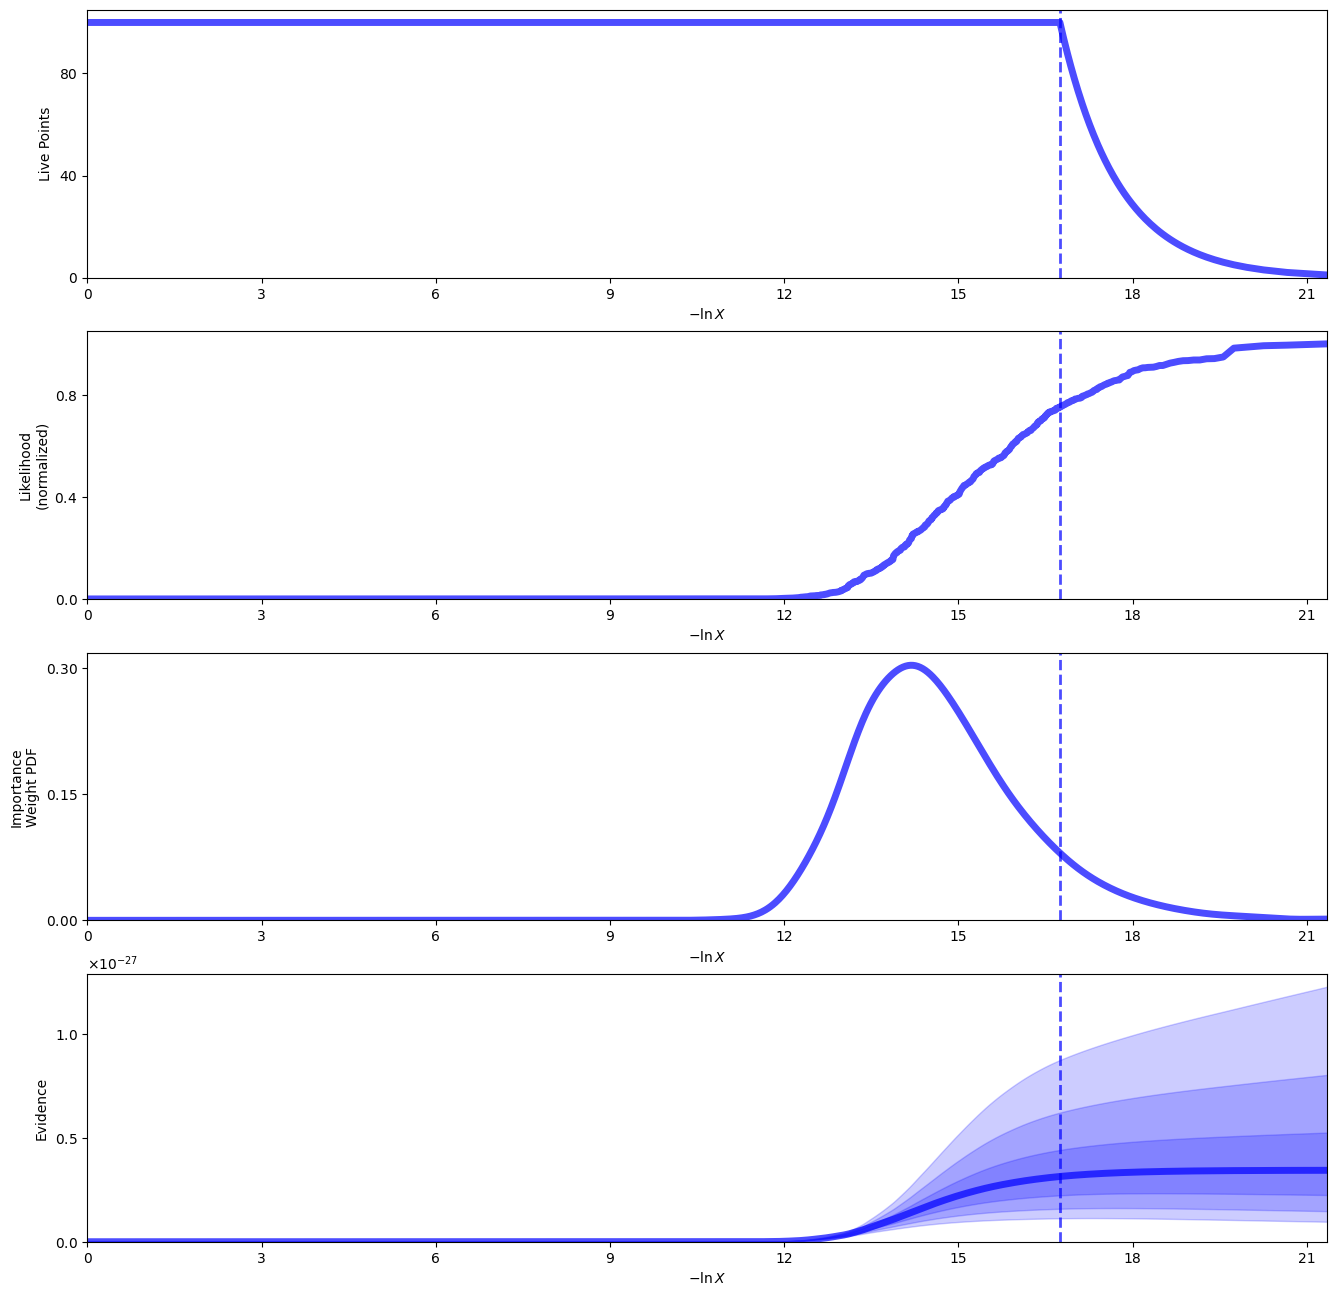

In [4]:
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

rfig, raxes = dyplot.runplot(results)

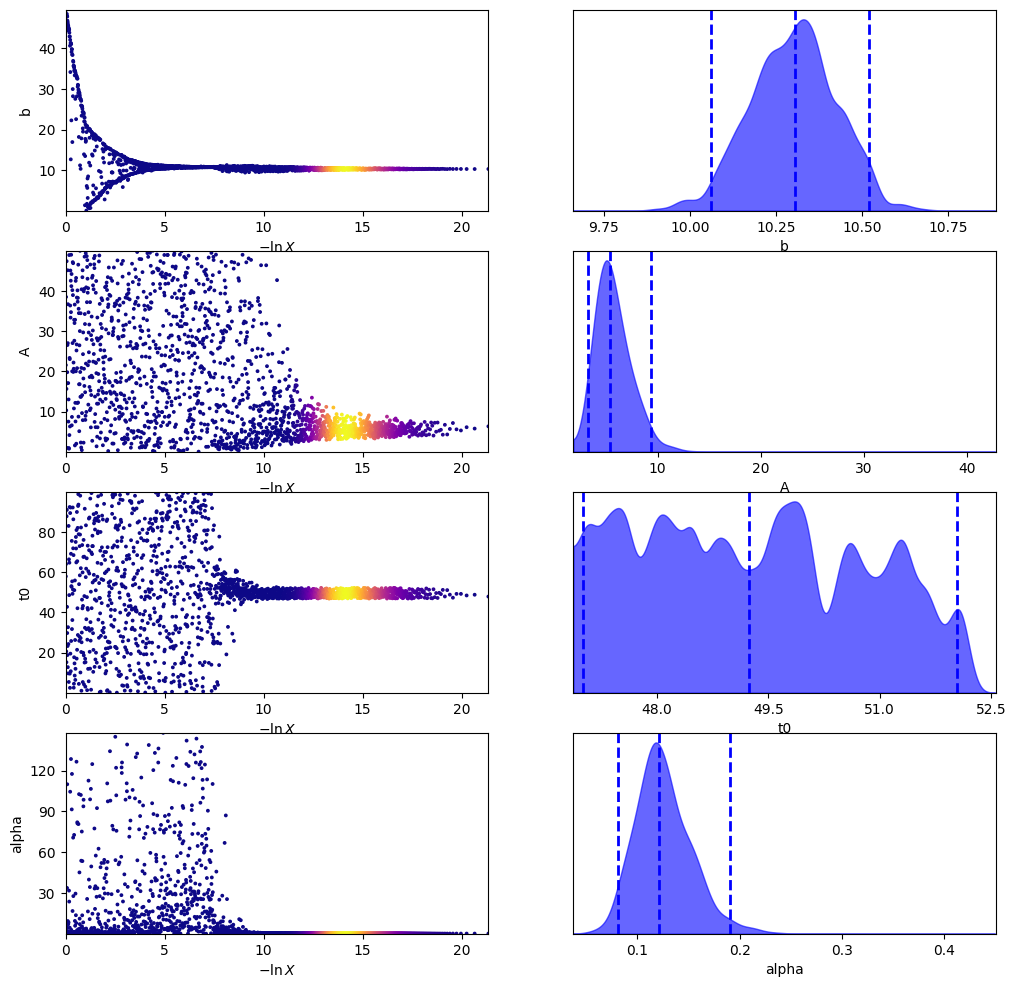

In [5]:
labels = ["b","A","t0","alpha"]
tfig, taxes = dyplot.traceplot(results, labels=labels)

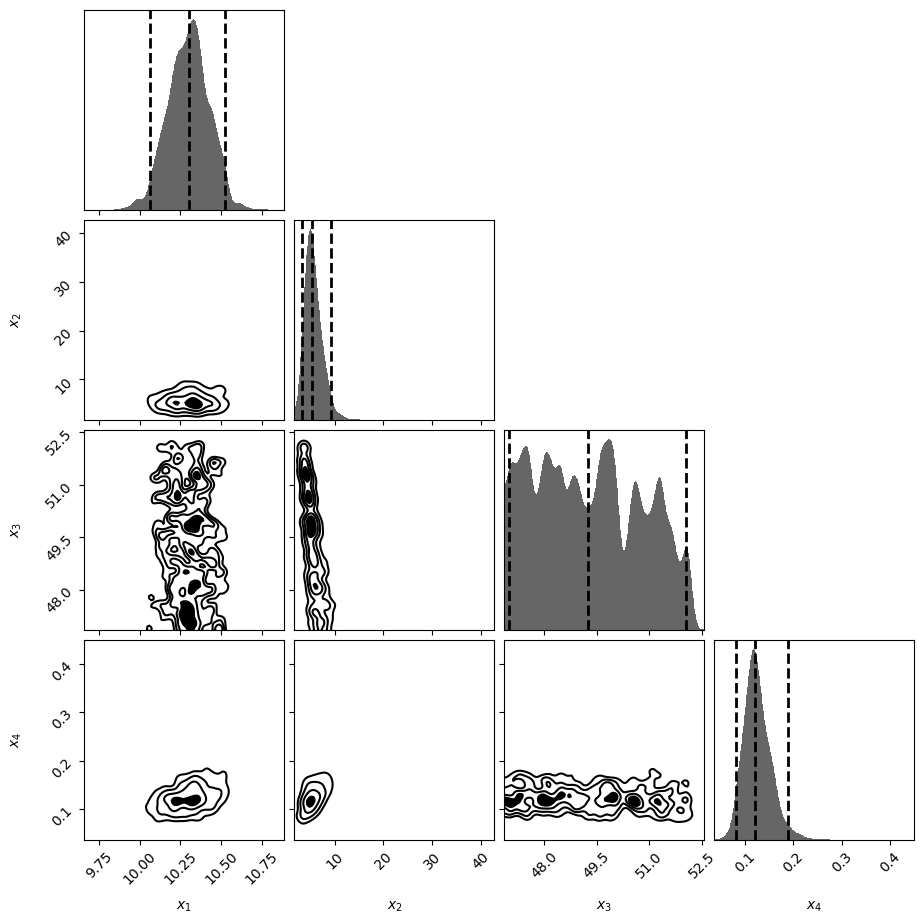

In [6]:
cfig, caxes = dyplot.cornerplot(results)

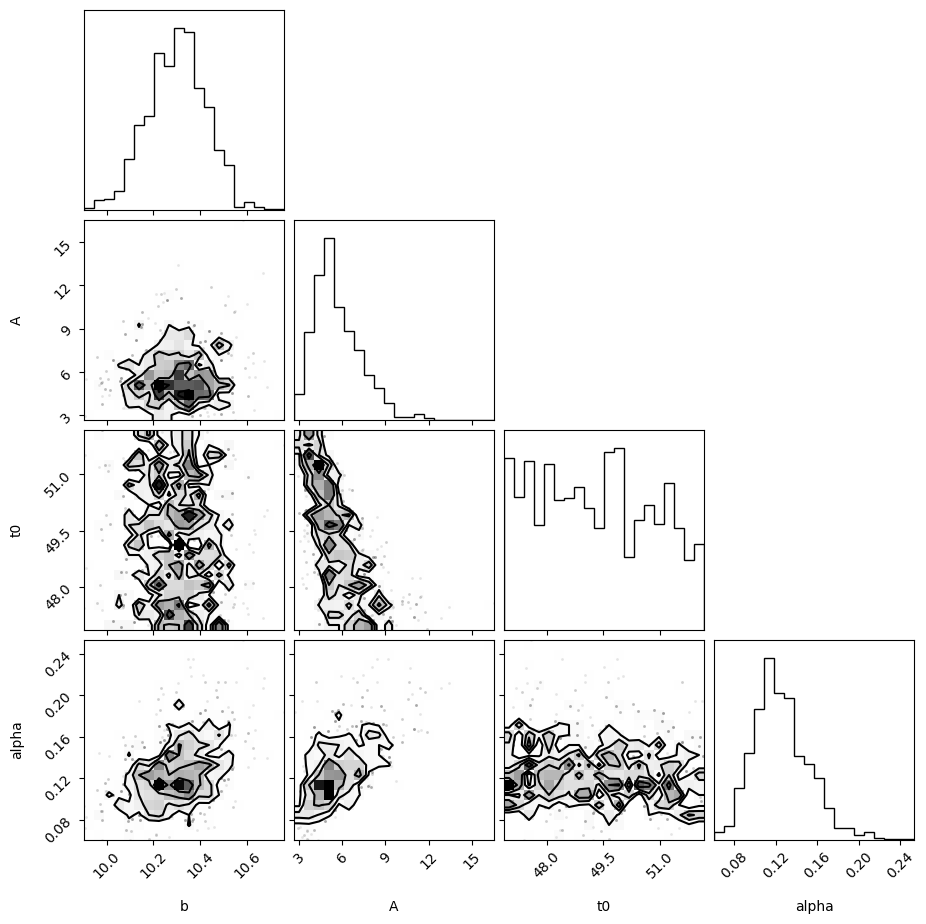

In [7]:
import corner 

samples = results.samples  
weights = np.exp(results.logwt - results.logz[-1])  

samples_equal = dyfunc.resample_equal(samples, weights)

corner.corner(samples_equal, labels=labels);

Results are similar to MCMC.

## Gauss model

In [49]:

ndim = 4
sampler = dynesty.NestedSampler(log_likelihood, prior, ndim, logl_args=[t, flux, err, gauss_model], ptform_args=[limits, 'gauss_model'], nlive = 100)
sampler.run_nested()
results_g = sampler.results

1796it [01:16, 23.62it/s, +100 | bound: 179 | nc: 1 | ncall: 32498 | eff(%):  5.852 | loglstar:   -inf < -52.431 <    inf | logz: -68.050 +/-  0.372 | dlogz:  0.001 >  0.109]


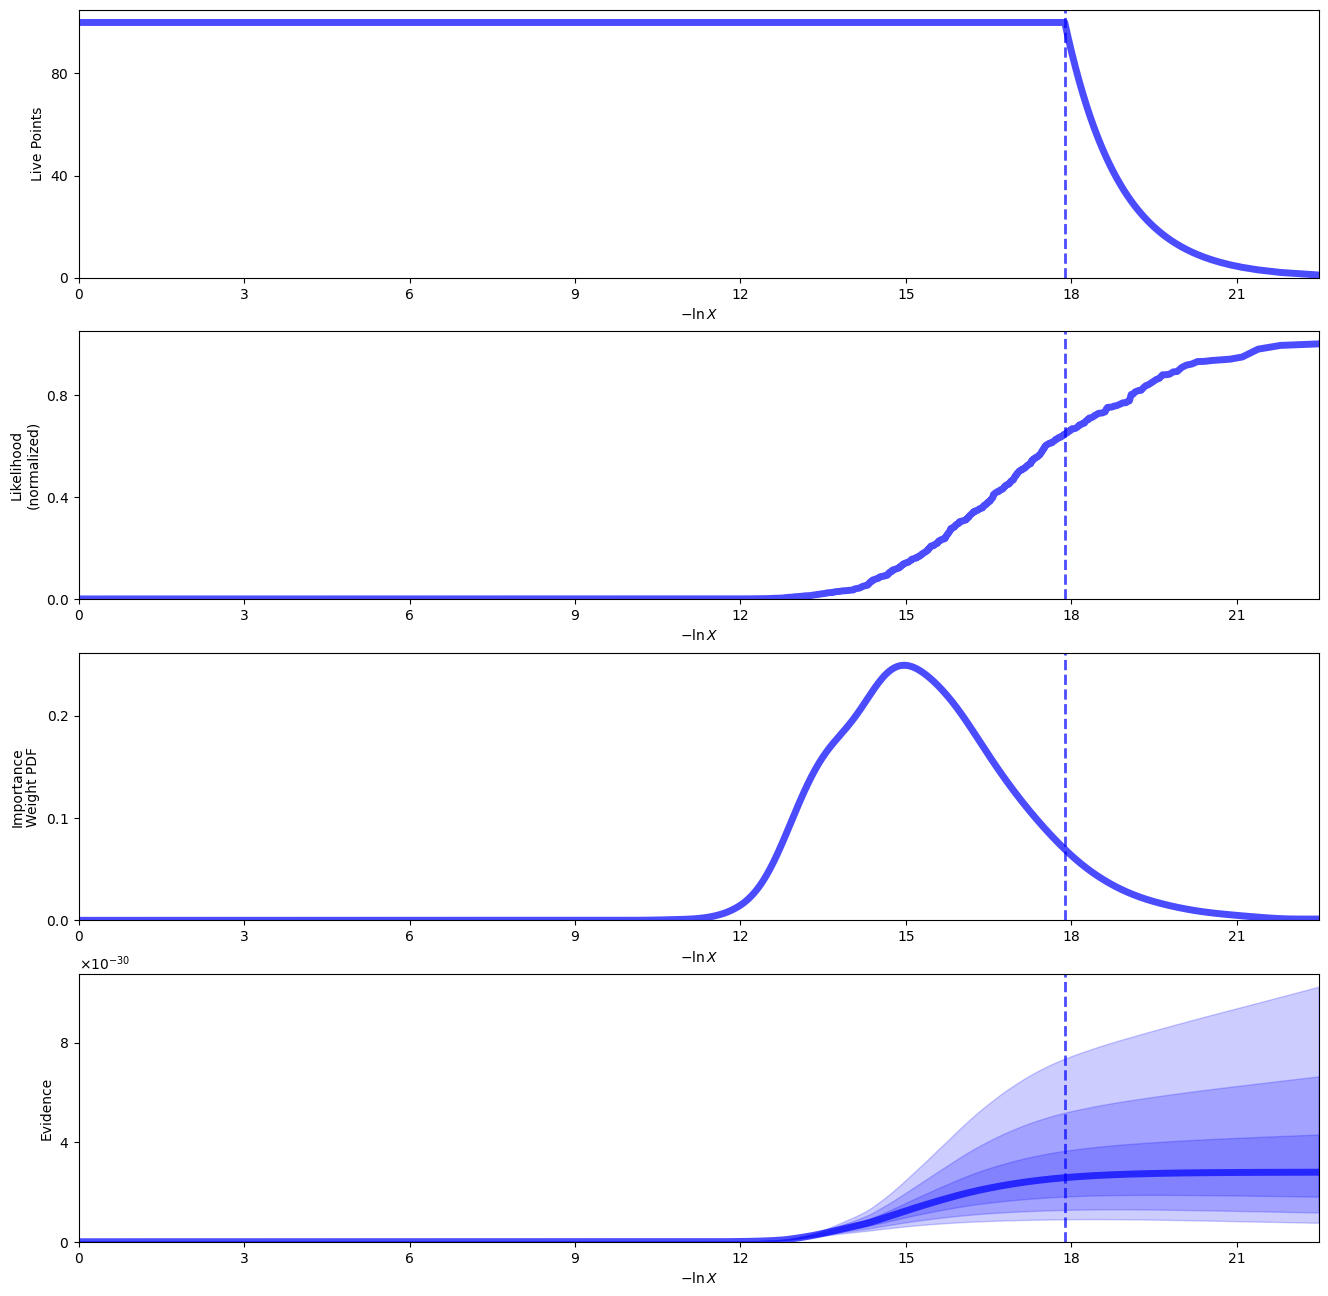

In [52]:
rfig, raxes = dyplot.runplot(results_g)

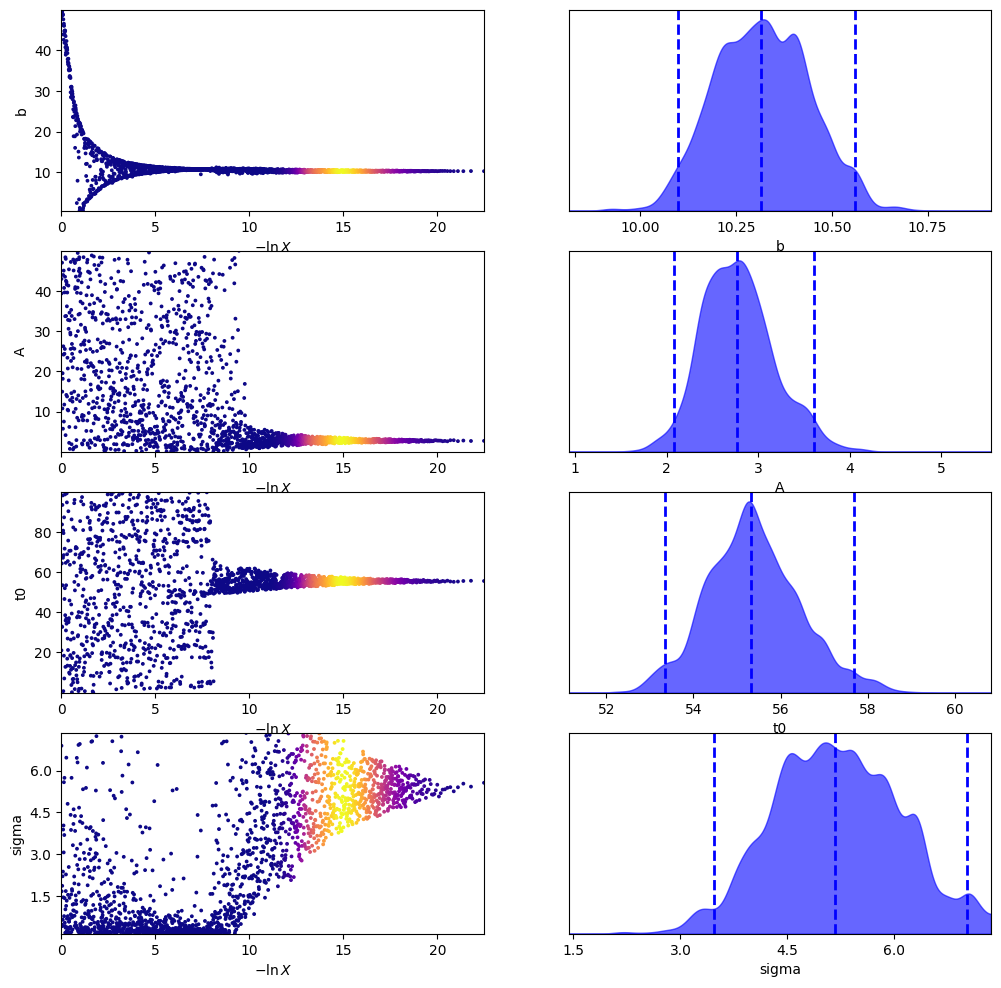

In [53]:
labels = ["b","A","t0","sigma"]
tfig, taxes = dyplot.traceplot(results_g, labels=labels)

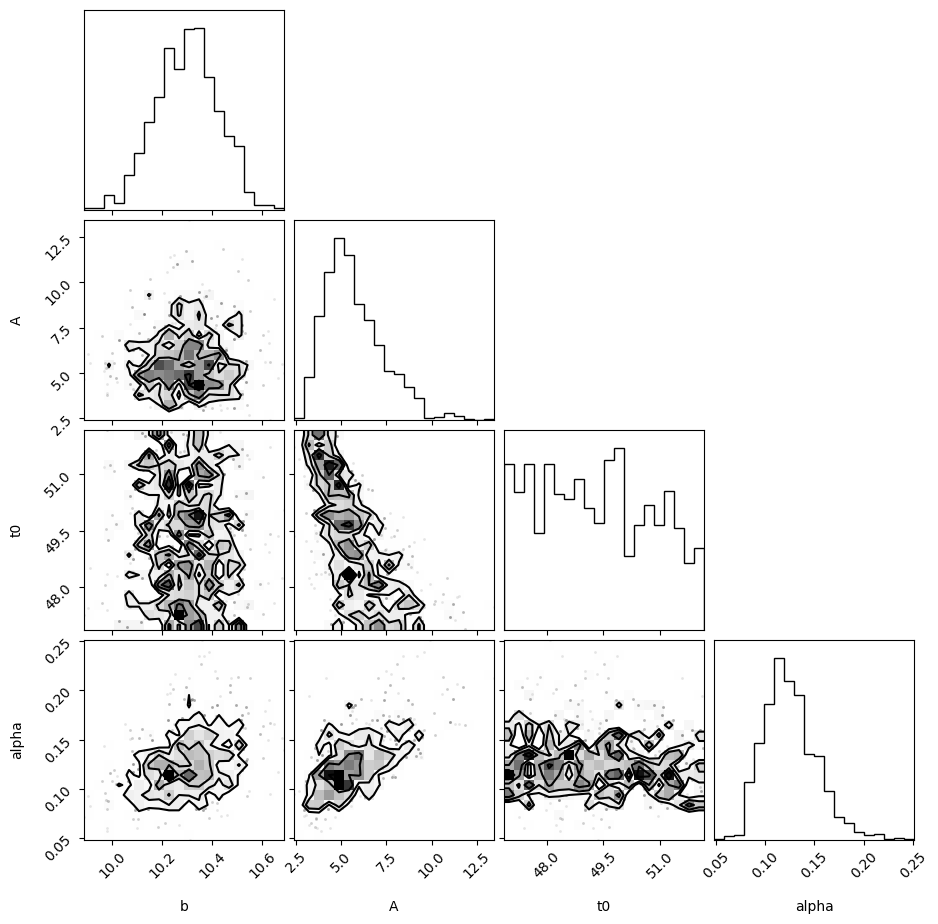

In [9]:
import corner 

samples = results.samples  
weights = np.exp(results.logwt - results.logz[-1])  

samples_equal_g = dyfunc.resample_equal(samples, weights)

corner.corner(samples_equal_g, labels=labels);

## Model comparison


In [58]:
# Burst model
results.summary()

Summary
nlive: 100
niter: 1735
ncall: 38025
eff(%):  4.826
logz: -63.776 +/-  0.433


In [59]:
#Gauss model
results_g.summary()

Summary
nlive: 100
niter: 1796
ncall: 32398
eff(%):  5.852
logz: -68.050 +/-  0.433


In [61]:
# Ratio Burst / Gauss
ratio = np.exp(results.logz[-1] - results_g.logz[-1])

print(f'Bayes factor = {ratio:.3}')

Bayes factor = 71.8


The burst model is strongly better

Text(0.5, 1.0, 'Model spread given parameter posteriors')

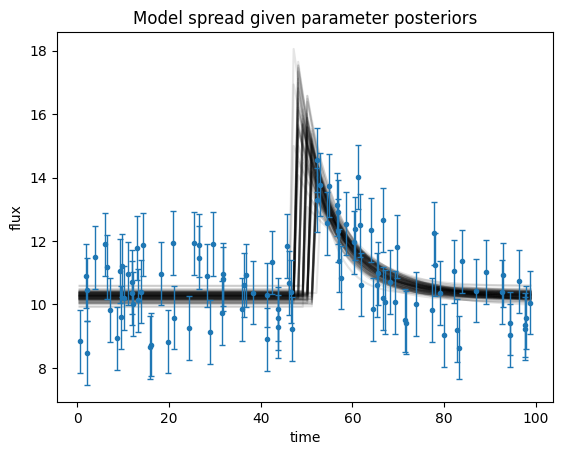

In [62]:
# 100 random samples
N_rand = 100
mask = np.random.choice(len(samples_equal), size = N_rand)
choices = samples_equal[mask]
grid = np.linspace(min(t), max(t), 100)

#plot
for choice in choices:
    plt.plot(grid, burst_model(choice, grid), c='k', alpha = .1)
    
plt.errorbar(t, flux, yerr = err, fmt ='.', capsize = 2, lw=1)

plt.xlabel("time")
plt.ylabel("flux")
plt.title('Model spread given parameter posteriors')

Text(0.5, 1.0, 'Model spread given parameter posteriors')

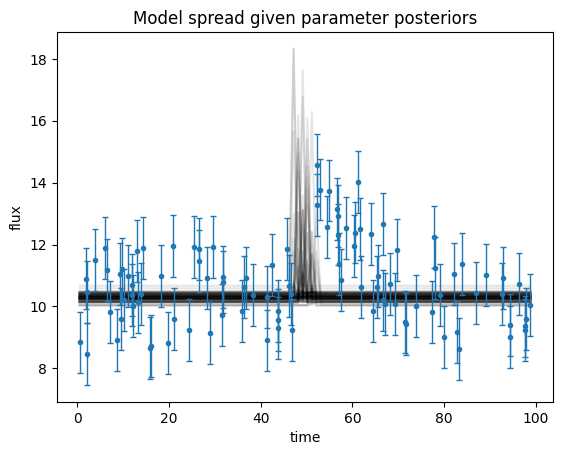

In [65]:
N_rand = 100
mask = np.random.choice(len(samples_equal_g), size = N_rand)
choices = samples_equal_g[mask]
grid = np.linspace(min(t), max(t), 100)

#plot
for choice in choices:
    plt.plot(grid, gauss_model(choice, grid), c='k', alpha = .1)
    
plt.errorbar(t, flux, yerr = err, fmt ='.', capsize = 2, lw=1)

plt.xlabel("time")
plt.ylabel("flux")
plt.title('Model spread given parameter posteriors')